# Lecture - Convolutional Neural Networks

Over the course of history, convolution operation has helped accelerate science and signal processing in a variety of ways. With the advent of deep learning, computer vision researchers began exploring the use of 2D and 3D convolutional neural networks (CNNs) directly on 2D or 3D images to reduce the parameters involved with fully connected deep neural networks. With large amount of data and computation at their disposal, supervised CNN learning algorithms tackled problems which were almost impossible to generalize in the past decade.

CNNs are impressive feature extractors, extracting features heirarchically from the training images during the learning process. First few layers close to the input data learns kernels related to high contrast points, edges, and lines. Layers further in the network learns to map these primitive kernels together to understand countours and other shapes. This heirarchical way of learning by representation enables complex pattern recognition that was impossible using traditional signal processing and machine learning algorithms.

In this notebook, we will learn how to define CNNs in PyTorch and build some functions to help us along the way.

In [41]:
import time
import torch
import itertools
import torchvision

import numpy as np
import torch.nn.functional as Functional
import matplotlib.pyplot as plt

from torch import nn, optim
from torchvision import datasets, transforms

from torch.utils.data import TensorDataset, DataLoader

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

flatten = itertools.chain.from_iterable

# Some helper functions

def plot_loss(loss_as_list):
    """
    Plot the loss curve from a list of loss terms.
    """
    plt.plot(loss_as_list, 'k')
    _ = plt.title("Loss Curve")
    _ = plt.xlabel("Epochs")
    _ = plt.ylabel("Loss")
    
def get_classification_results(model, loader):
    """
    Print the accuracy of a trained model.
    Loss: Cross Entropy
    """
    correct, total = 0, 0
    predictions = []
    true_labels = []

    for xs, ts in test_loader:
        zs = model(xs) # do forward pass
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        correct += pred.eq(ts.view_as(pred)).sum().item() # count equal values
        total += int(ts.shape[0]) # get total values

        predictions.append(pred)
        true_labels.append(ts)

    accuracy = correct / total
    conf_matrix = confusion_matrix(list(flatten(true_labels)), list(flatten(predictions)))
    cl_report = classification_report(list(flatten(true_labels)), list(flatten(predictions)), digits=4)
    
    print("Classification Report")
    print(cl_report)
    print("Confusion Matrix")
    print(conf_matrix)

In [42]:
torch.manual_seed(13)

N_train = 64
N_test = 256

# We will use torch.utils.data.DataLoader to wrap our dataset.
# This provides easier batching, GPU support, etc.
# Calling torchvision.datasets.MNIST() will download and format the MNIST
# dataset with the transforms we specify. Here, in the transforms we first convert
# the image to PyTorch tensor, and then normalize the image based on a given mean
# and standard deviation. Normalizing the image does: image = (image - mean) / std.
# We shuffle the data as well by defining shuffle=True.

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('../Datasets/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=N_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('../Datasets/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=N_test, shuffle=False)

In [43]:
test_subset = enumerate(test_loader)
batch_idx, (one_batch_of_test_subset_x, one_batch_of_test_subset_y) = next(test_subset)

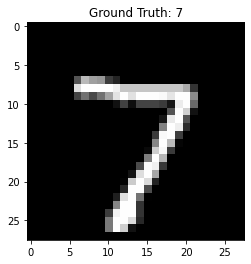

In [44]:
i = 0
plt.imshow(one_batch_of_test_subset_x[i][0], cmap='gray', interpolation='none')
_ = plt.title("Ground Truth: {}".format(one_batch_of_test_subset_y[i]))
number7 = one_batch_of_test_subset_x[i][0]

## Convolutional Neural Networks - API level discussions

PyTorch has implementations for 1D, 2D, and 3D convolutions. Perhaps, in this lecture, the main focus will be on [Conv2D](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d) function from Pytorch. The class attributes are as below:

```python
class torch.nn.Conv2d(
    in_channels: int, 
    out_channels: int, 
    kernel_size: Union[T, Tuple[T, T]], 
    stride: Union[T, Tuple[T, T]] = 1, 
    padding: Union[T, Tuple[T, T]] = 0, 
    dilation: Union[T, Tuple[T, T]] = 1, 
    groups: int = 1, 
    bias: bool = True, 
    padding_mode: str = 'zeros')
```

This is a good time to introduce a new way to define our neural network models. So far, we have been using the `nn.Sequential` APIs to define our network in a systematic sequential way. But, as we move into more complex neural network architectures, we might be limited by sequential nature of data and gradient flow. We will redefine our network as a `class` with an `__init__` method and `forward` function to carry out the forward pass. Let's look at our new model which we name `CNN_A`.

![alt text](images/CNN_A.png "CNN_A architecture")

In [45]:
class CNN_A(nn.Module):
    def __init__(self):
        super(CNN_A, self).__init__()
        # We can define the arguments of each layer in the __init__ method.
        # __init__ method will be called everytime we create an object of this class.
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(1600, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        # This is the forward pass function.
        # See how we can save the activation outputs of each layer into a variable.
        # In this case, we are saving the output of each layer
        # to the same variable and replacing the value every time
        # before sending to a new layers.
        # conv layer 1
        x = self.conv1(x)
        # maxpooling 2D
        x = Functional.max_pool2d(x, 2)
        # ReLU non-linearity
        x = Functional.relu(x)
        # conv layer 2
        x = self.conv2(x)
        # maxpooling 2D
        x = Functional.max_pool2d(x, 2)
        # ReLU non-linearity
        x = Functional.relu(x)
        # Dropout
        x = self.dropout1(x)
        # Flatten
        x = torch.flatten(x, 1)
        
        # FC1
        x = self.fc1(x)
        x = Functional.relu(x)
        x = self.dropout2(x)
        
        # FC2
        x = self.fc2(x)
        
        #FC3
        x = self.fc3(x)
        return x

In [46]:
model = CNN_A()

In [47]:
model

CNN_A(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [48]:
model.forward

<bound method CNN_A.forward of CNN_A(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)>

As we can see, we loose the ability to see the model structure by printing the variable. But the `forward` function is very readable.

In [7]:
def model_summary(model):
    """
    Returns the number of parameters (trainable and total) of a PyTorch model.
    """
    print("Trainable parameter variables: {}\nTotal number of parameters: {}\nTotal number of trainable parameters: {}".format(
        len(list(model.parameters())),
        sum(p.numel() for p in model.parameters()),
        sum(p.numel() for p in model.parameters() if p.requires_grad))
         )

In [8]:
model_summary(model)

Trainable parameter variables: 10
Total number of parameters: 232650
Total number of trainable parameters: 232650


### Output shapes of convolution layer

$$\frac{W−K+2P}{S} +1$$

- W is the input volume
- K is the kernel size
- P is the amount of padding
- S is the stride size

![alt text](images/convolution_basic.gif "Convolution Operation")

In [9]:
W = 5
K = 3
P = 0
S = 1

out_shape = ((W-K+2*P)//S) + 1
print("Shape of convolved activations: ", out_shape)

Shape of convolved activations:  3


### Convolution in the RGB domain

![alt text](images/convolution.gif "Convolution Operation")

In [10]:
W = 5
K = 3
P = 1
S = 2

out_shape = ((W-K+2*P)//S) + 1
print("Shape of convolved activations: ", out_shape)

Shape of convolved activations:  3


### Conv shapes of our CNN_A

In [11]:
W = 28
K = 3
P = 0
S = 1

conv1_out = ((W-K+2*P)//S) + 1
print("Shape of CONV1 activations: ", conv1_out)

maxpool_of_conv1 = conv1_out//2

print("Shape of MaxPool output: ", maxpool_of_conv1)

conv2_out = ((maxpool_of_conv1-K+2*P)//S) + 1
print("Shape of CONV1 activations: ", conv2_out)

maxpool_of_conv2 = conv2_out//2

print("Shape of MaxPool output: ", maxpool_of_conv2)



Shape of CONV1 activations:  26
Shape of MaxPool output:  13
Shape of CONV1 activations:  11
Shape of MaxPool output:  5


In [12]:
[p.numel() for p in model.parameters() if p.requires_grad]

[288, 32, 18432, 64, 204800, 128, 8192, 64, 640, 10]

### Parameters of the CNN - let's hand calculate.
> https://www.learnopencv.com/number-of-parameters-and-tensor-sizes-in-convolutional-neural-network/

$W_c$ = Number of weights of the Conv Layer.

$B_c$ = Number of biases of the Conv Layer.

$P_c$ = Number of parameters of the Conv Layer.

$K$ = Size (width) of kernels used in the Conv Layer.

$N$ = Number of kernels.

$C$ = Number of channels of the input image.

$$\begin{align*}  W_c &= K^2 \times C \times N \\ B_c &= N \\ P_c &= W_c + B_c \end{align*}$$

In [13]:
# Conv1 

K = 3 # filter size
C = 1 # channels from the previous layer
N = 32 # channels in the current layer
Wc = K**2 * C * N
print("Parameters = Weight: {}, Biases: {}".format(Wc, N))

Parameters = Weight: 288, Biases: 32


In [14]:
# Conv2

K = 3
C = 32
N = 64
Wc = K**2 * C * N
print("Parameters = Weight: {}, Biases: {}".format(Wc, N))

Parameters = Weight: 18432, Biases: 64


### Parameters between Conv and FC

$W_{cf}$ = Number of weights of a FC Layer which is connected to a Conv Layer.

$B_{cf}$ = Number of biases of a FC Layer which is connected to a Conv Layer.

$O$ = Size (width) of the output image of the previous Conv Layer.

$N$ = Number of kernels in the previous Conv Layer.

$F$ = Number of neurons in the FC Layer.

$$\begin{align*} W_{cf} &= O^2 \times N \times F \\ B_{cf} &= F \\ P_{cf} &= W_{cf} + B_{cf} \end{align*}$$

In [15]:
# Flatten - FC1

O = 5 # maxpool output
N = 64 # number of channels
F = 128 # number of nodes in fully connected layer
Wcf = O**2 * N * F
print("Parameters = Weight: {}, Biases: {}".format(Wcf, F))

Parameters = Weight: 204800, Biases: 128


### Parameters between FC and FC

$W_{ff}$ = Number of weights of a FC Layer which is connected to an FC Layer.

$B_{ff}$ = Number of biases of a FC Layer which is connected to an FC Layer.

$P_{ff}$ = Number of parameters of a FC Layer which is connected to an FC Layer.

$F$ = Number of neurons in the FC Layer.

$F_{-1}$ = Number of neurons in the previous FC Layer.

$$\begin{align*} W_{ff} &= F_{-1} \times F \\  B_{ff} &= F \\ P_{ff} &= W_{ff} + B_{ff}   \end{align*}$$

In [17]:
# Flatten - FC2

Fm1 = 128 # number of nodes in the previous fully connected layer
F = 64 # number of nodes in fully connected layer
Wff = Fm1 * F
print("Parameters = Weight: {}, Biases: {}".format(Wff, F))

Parameters = Weight: 8192, Biases: 64


In [18]:
# Flatten - FC3

Fm1 = 64 # number of nodes in the previous fully connected layer
F = 10 # number of nodes in fully connected layer
Wff = Fm1 * F
print("Parameters = Weight: {}, Biases: {}".format(Wff, F))

Parameters = Weight: 640, Biases: 10


### Training the CNN

We will reuse the training code from Assignment 1 and remove the line of code where we flatten the input image.

In [49]:
def train(model, NUM_EPOCHS, train_loader, device):
    """
    A function to train the neural network model.
    """
    # 
    loss_fn = nn.CrossEntropyLoss() # also called criterion sometimes.

    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9) #SGD - Stochastic Gradient Descent
    start = time.time()
    loss_as_list = []

    for EPOCH in range(NUM_EPOCHS):
        running_loss = 0
        for images, labels in train_loader:

            # Training pass
            optimizer.zero_grad()

            output = model(images.to(device)) #forward pass
            
            loss = loss_fn(output, labels.to(device))
            loss_as_list.append(loss)

            #This is where the model learns by backpropagating
            loss.backward()

            #And optimizes its weights here
            optimizer.step()

            running_loss += loss.item()
        else:
            print("Epoch {} - Training loss: {}".format(EPOCH, running_loss/len(train_loader)))

    print("\nTraining Time (in minutes) =",(time.time()-start)/60)
    return(loss_as_list)

In [54]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to('cuda')

In [55]:
# Hyper Parameters
lr = 0.003 # learning rate
NUM_EPOCHS = 4

loss_values = train(model, NUM_EPOCHS, train_loader, device)

Epoch 0 - Training loss: 0.5414844282718101
Epoch 1 - Training loss: 0.16635377452508218
Epoch 2 - Training loss: 0.12366752741909993
Epoch 3 - Training loss: 0.10201915525503631

Training Time (in minutes) = 1.166442827383677


### Saving a trained model

In [56]:
torch.save(model, 'cnn_a_model.pt')
print("Model saved.. ")

Model saved.. 


### Loading a trained model

In [57]:
model = torch.load('cnn_a_model.pt')
print("Loaded the saved model")

Loaded the saved model


### Performance evaluation

In [58]:
get_classification_results(model.to('cpu'), test_loader)

Classification Report
              precision    recall  f1-score   support

           0     0.9815    0.9765    0.9790       980
           1     0.9850    0.9868    0.9859      1135
           2     0.9745    0.9612    0.9678      1032
           3     0.9732    0.9703    0.9717      1010
           4     0.9804    0.9695    0.9749       982
           5     0.9400    0.9843    0.9617       892
           6     0.9915    0.9697    0.9805       958
           7     0.9680    0.9708    0.9694      1028
           8     0.9611    0.9641    0.9626       974
           9     0.9526    0.9564    0.9545      1009

    accuracy                         0.9710     10000
   macro avg     0.9708    0.9710    0.9708     10000
weighted avg     0.9712    0.9710    0.9710     10000

Confusion Matrix
[[ 957    0    3    0    3    3    3    1    4    6]
 [   0 1120    3    1    0    2    2    1    6    0]
 [   2    5  992    7    0    0    0   12   13    1]
 [   0    0    2  980    0   17    0    5  